# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

sum_sq    df         F    PR(>F)  p_val_adj
A1BG   0.122578  12.0  2.796490  0.003701   0.010364
AAAS   0.017527  12.0  0.944161  0.509517   0.596369
AACS   0.136394  12.0  2.729393  0.004508   0.012212
AADAT  0.057031  12.0  5.478881  0.000002   0.000016
AAGAB  0.043359  12.0  2.127609  0.026045   0.053640

In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = '../data/pseudobulks/'

In [8]:
os.listdir(pb_dir_path)

['pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [11]:
import pickle
with open("./results/specie_specific_genes_tr77.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

## Helpful functions

In [12]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [13]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [14]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [15]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [16]:
ms_genes = genes_dict77['macaque']

In [17]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_ms = df[ms_genes]

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


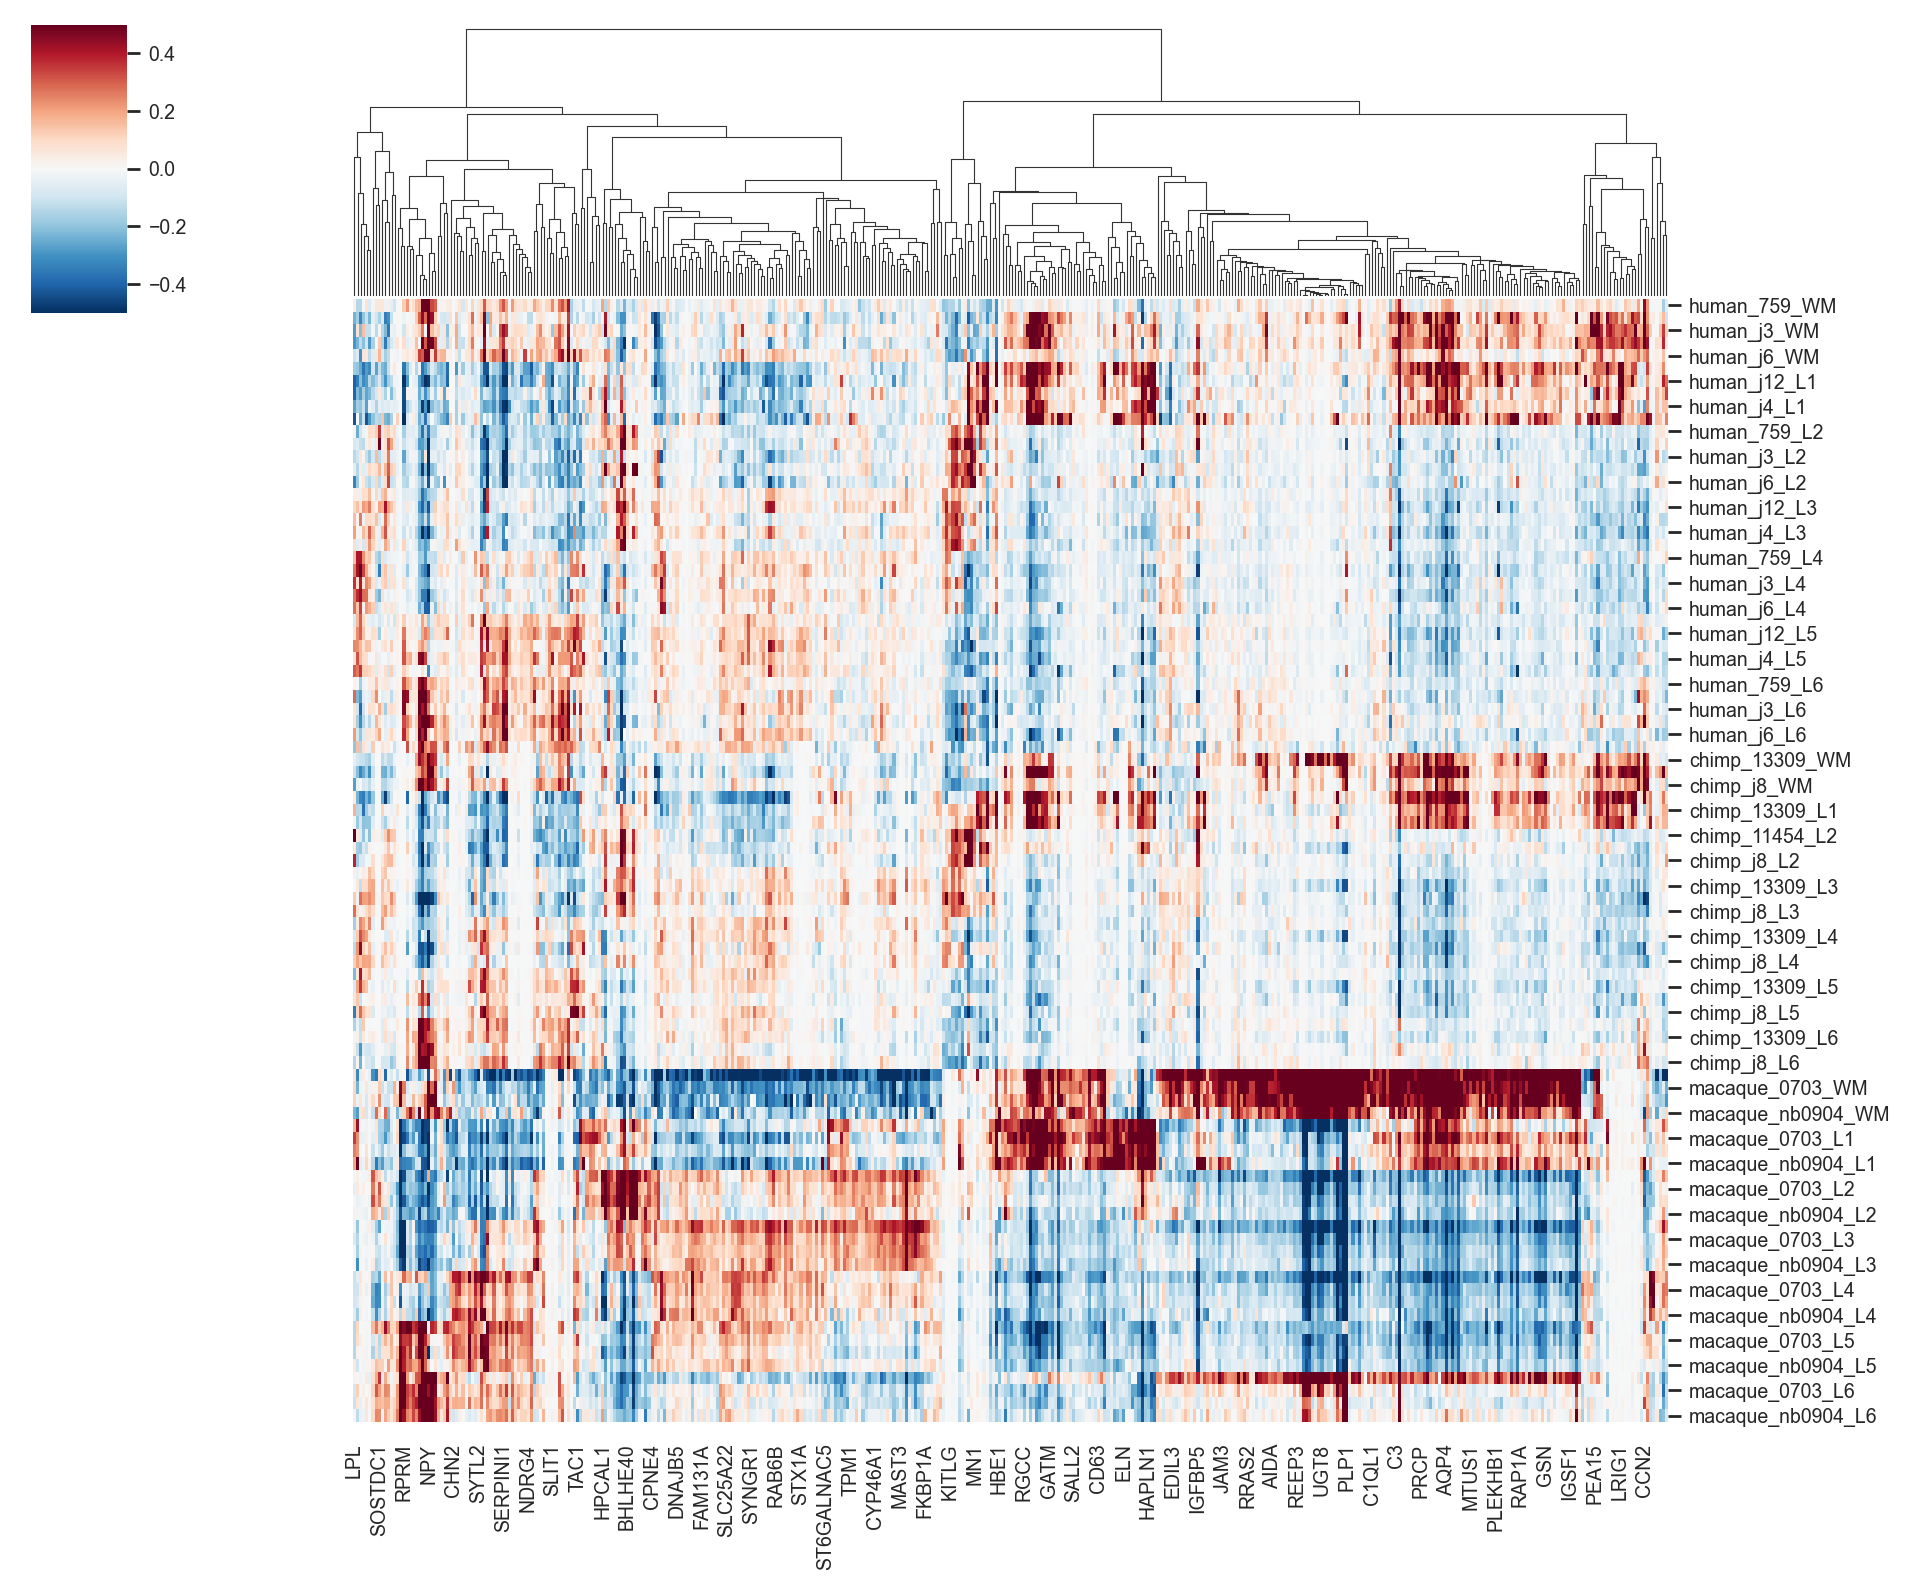

In [18]:
sns.set(font_scale=0.8)
sns.clustermap(df_ms, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [19]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_ms.loc[sample_order['macaque']].T, metric='cosine') + 1
n_clusters = 4
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)

SpectralClustering(affinity='precomputed', gamma=1, n_clusters=4,
                   random_state=4)

In [20]:
labels = pd.Series(clustering.labels_, index=ms_genes).sort_values()
order = labels.sort_values().index

In [21]:
labels.to_csv('./results/macaque_clusters_77.csv')

<Axes: >

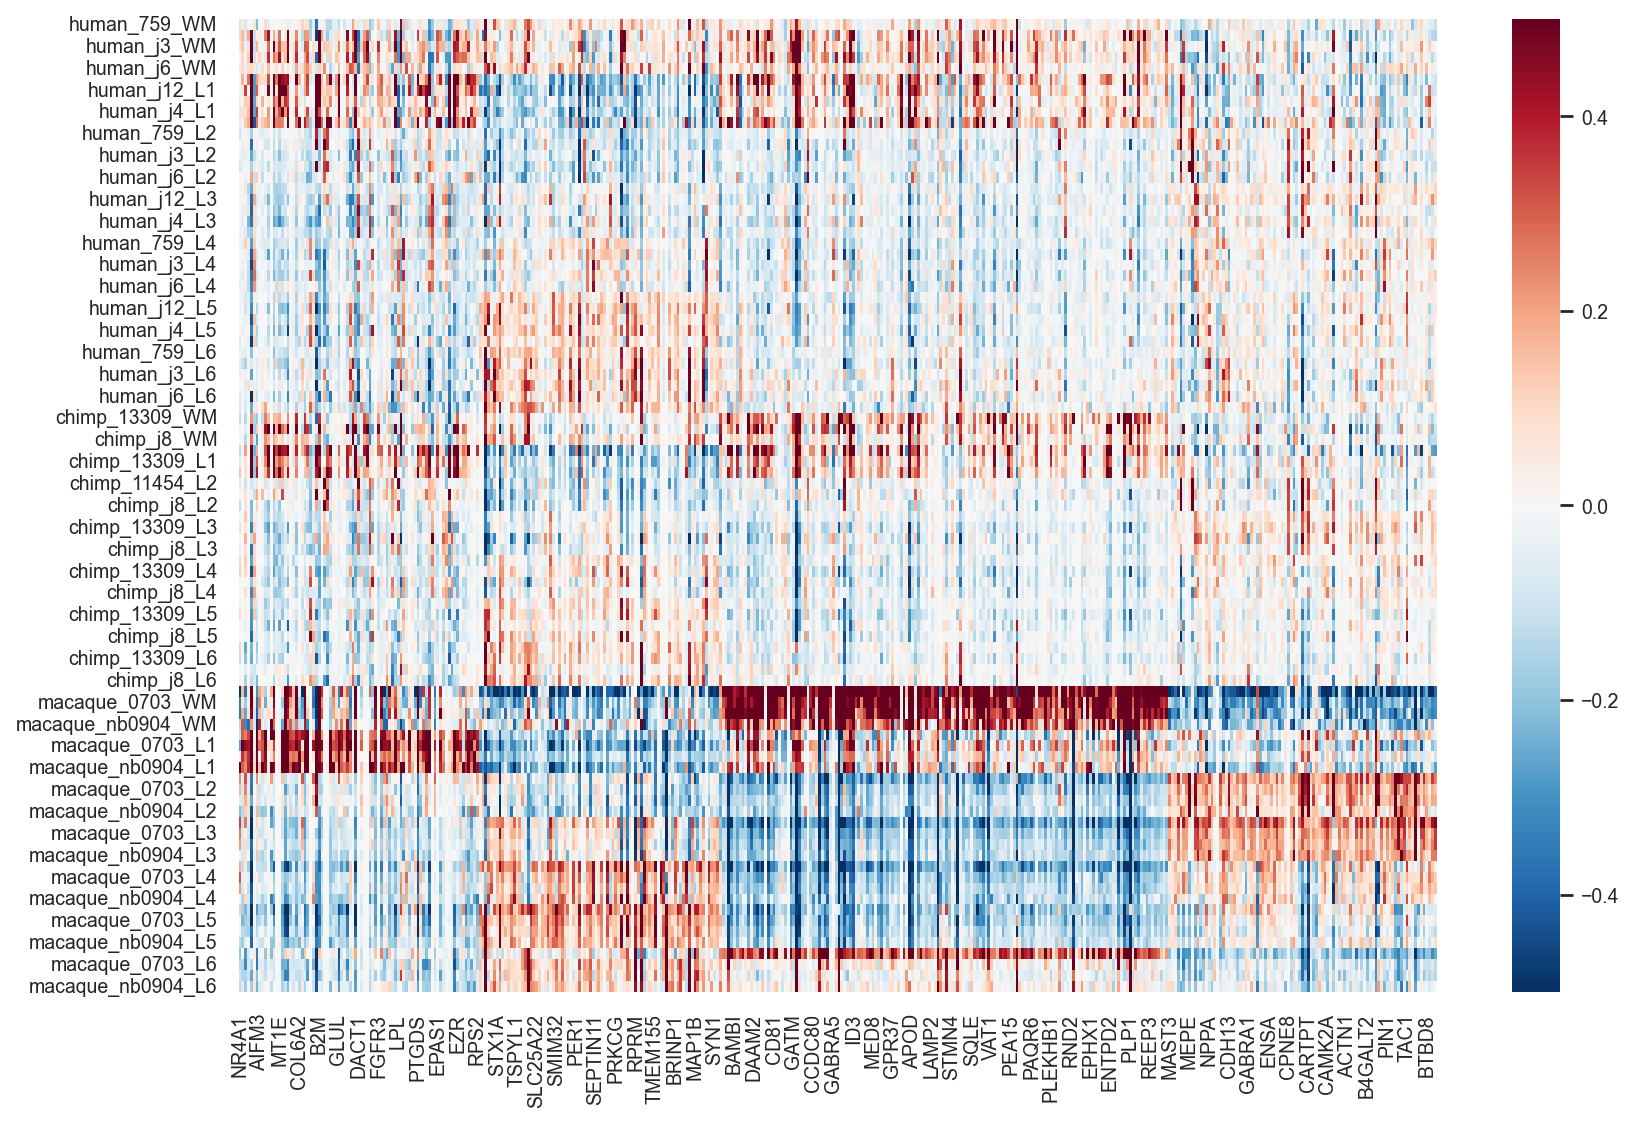

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_ms[order], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)

## Cluster profiles

In [23]:
df_annotation = df_ms.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [24]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

AATK   ABHD17B    ACAD10     ACBD7     ACTN1  ADCYAP1R1  \
condition layer                                                                
chimp     L1    -0.030878 -0.001759  0.010473  0.006301 -0.015202  -0.001043   
          L2    -0.065565  0.016788 -0.015965 -0.003049 -0.015137  -0.001043   
          L3    -0.000613 -0.010303 -0.001861 -0.000570  0.002908   0.001164   
          L4     0.005079 -0.004731  0.006279 -0.002516  0.012166   0.001704   
          L5     0.047233 -0.002512 -0.008272  0.001743 -0.007923   0.000260   

                     ADD3       AGT      AIDA     AIFM3  ...       VIM  \
condition layer                                          ...             
chimp     L1     0.432177  0.021529 -0.068123 -0.000345  ...  1.176994   
          L2    -0.107609 -0.007189  0.021937 -0.000345  ... -0.096151   
          L3    -0.223540 -0.003313 -0.001330  0.000418  ... -0.263862   
          L4    -0.219780 -0.015196 -0.024405 -0.000252  ... -0.305315   
          L5    -0.144141 -0.011233  0.016382  0.000692  ... -0.302764   

                      VIT     VSNL1    VSTM2L       VXN      WIF1   ZCCHC12  \
condition layer                                                               
chimp     L1    -0.003224 -0.341156 -0.187876 -0.018511  0.117370 -0.001659   
          L2     0.015092 -0.156568  0.120600  0.008265  0.011345  0.004995   
          L3    -0.003124  0.153015  0.182693  0.002524  0.115427 -0.002203   
          L4    -0.014844  0.179942  0.088341 -0.006386  0.077161 -0.002203   
          L5    -0.000641  0.127961  0.074436 -0.005421 -0.011321  0.001126   

                   ZDHHC9   ZFP36L2    ZNF483  
condition layer                                
chimp     L1    -0.016036  0.272053  0.011409  
          L2    -0.027506 -0.027163 -0.008616  
          L3    -0.028847 -0.119889 -0.002111  
          L4    -0.023085 -0.105188 -0.003121  
          L5    -0.005882 -0.071453 -0.000806  

[5 rows x 424 columns]

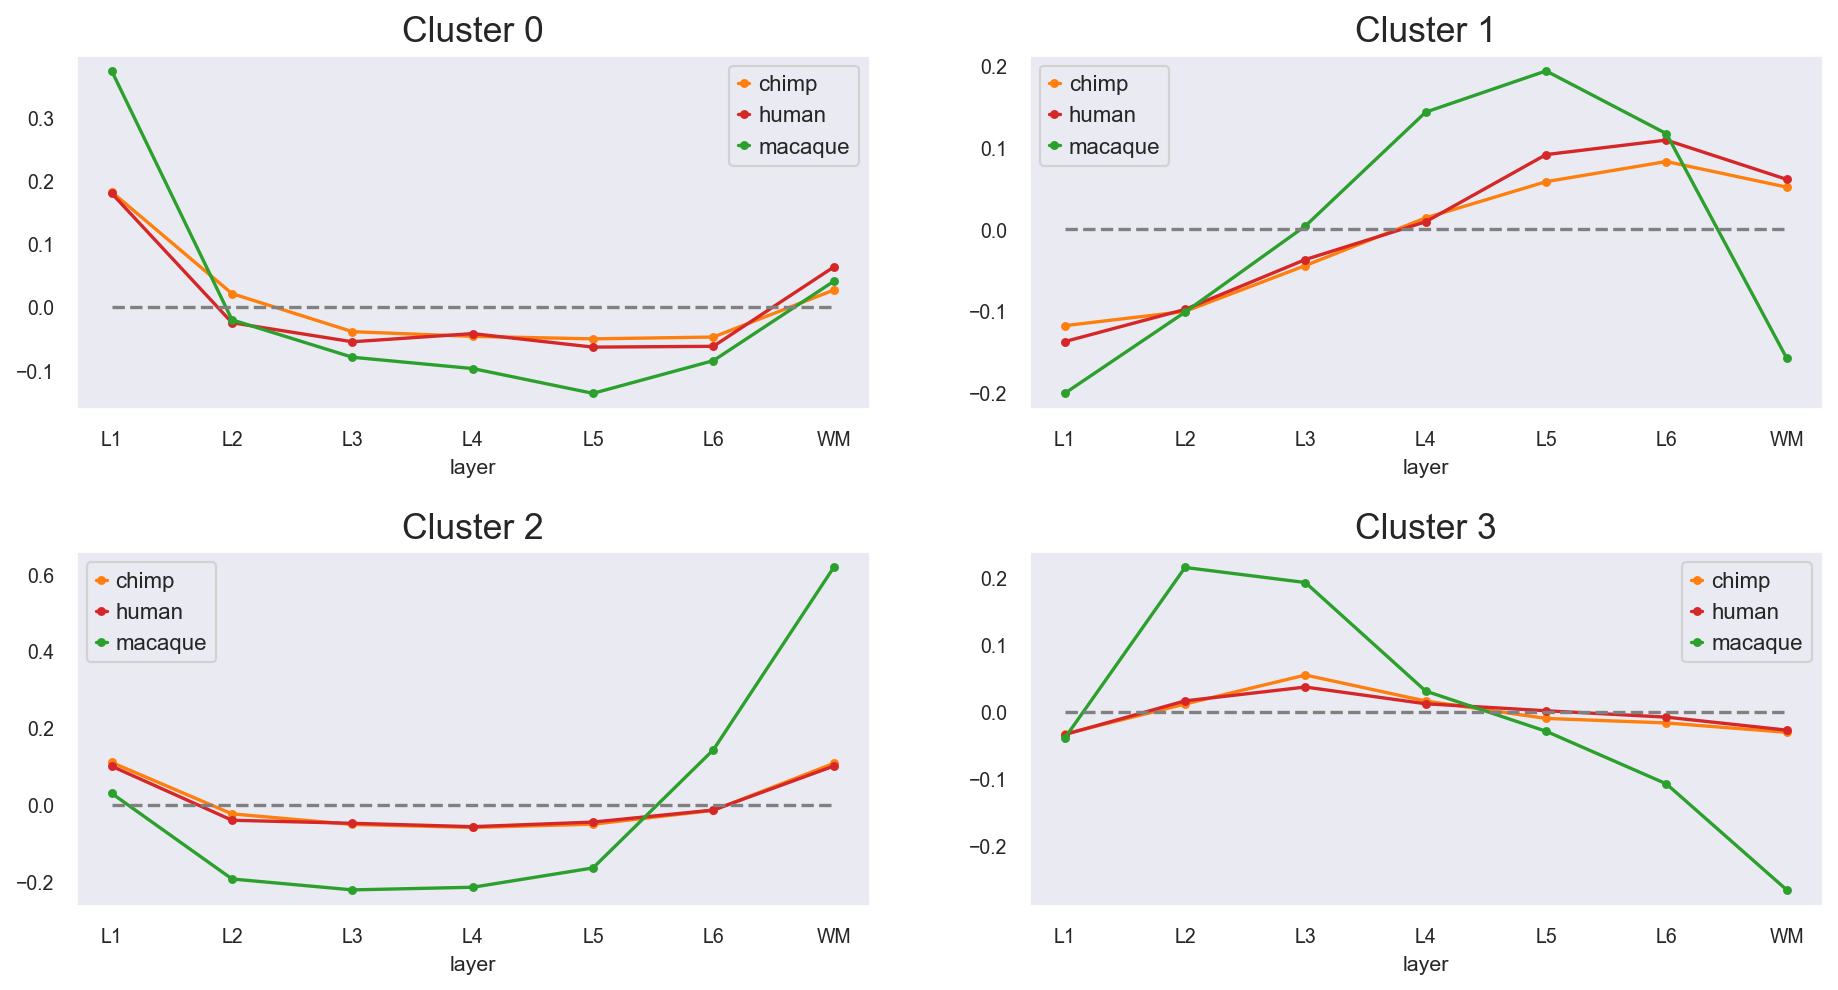

In [25]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

# Intersection with ANOVA clusters

In [26]:
anova_ms_inter = ms_genes.intersection(anova_labels.index)
anova_ms_inter

Index(['AATK', 'ABHD17B', 'ACAD10', 'ACBD7', 'ACTN1', 'ADCYAP1R1', 'ADD3',
       'AGT', 'AIDA', 'AIFM3',
       ...
       'VIM', 'VIT', 'VSNL1', 'VSTM2L', 'VXN', 'WIF1', 'ZCCHC12', 'ZDHHC9',
       'ZFP36L2', 'ZNF483'],
      dtype='object', length=415)

In [27]:
table_to_pivot = pd.concat([anova_labels.loc[anova_ms_inter], labels.loc[anova_ms_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'ms_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

ms_labels        0     1      2     3
ANOVA_labels                         
0             10.0   4.0    3.0   7.0
1              2.0  52.0    2.0   3.0
2              4.0   5.0    2.0   2.0
3              2.0   0.0  122.0   0.0
4             35.0   2.0    7.0   4.0
5              3.0  18.0    0.0  76.0
6             24.0   4.0   20.0   2.0

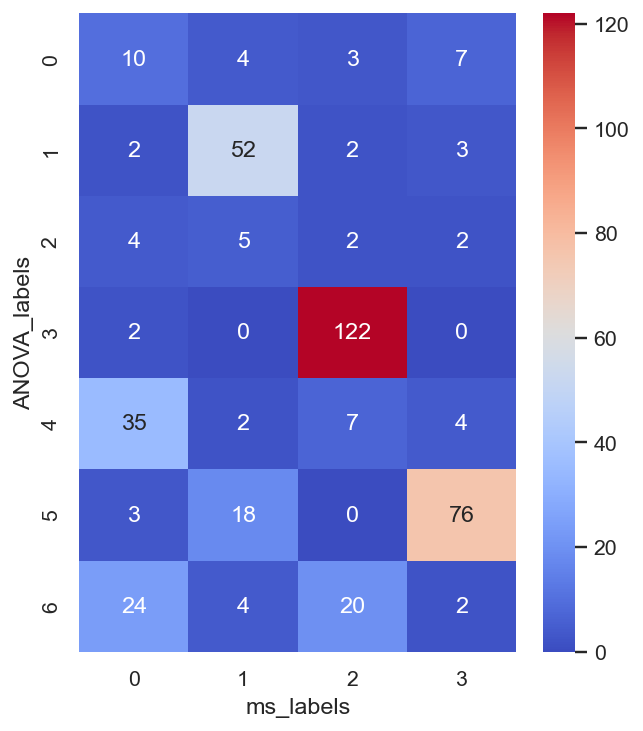

In [29]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

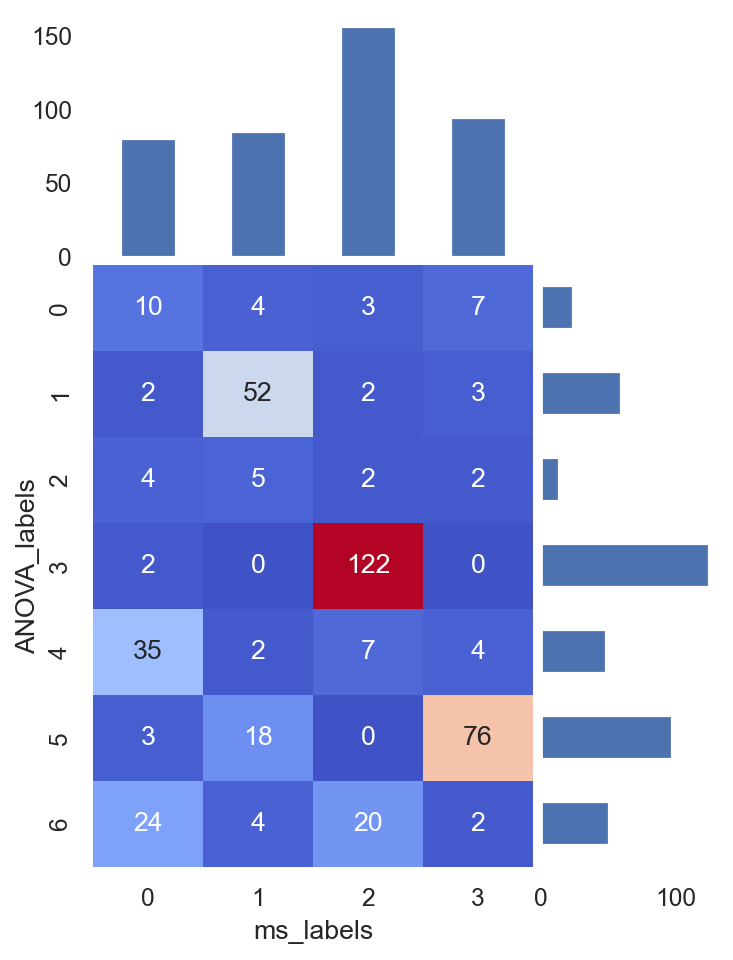

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', center=60, fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [31]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of macaque-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/4 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [32]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [33]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank         p-val  \
Term                                                                     
negative regulation of long-term synaptic poten...     1  2.317544e-07   
regulation of long-term synaptic potentiation (...     2  1.757428e-06   
negative regulation of endothelial cell migrati...     3  4.357837e-05   
external encapsulating structure organization (...     4  4.970456e-05   
extracellular structure organization (GO:0043062)      5  5.375905e-05   

                                                       Z-score  \
Term                                                             
negative regulation of long-term synaptic poten...  150.123457   
regulation of long-term synaptic potentiation (...   31.614583   
negative regulation of endothelial cell migrati...   24.979424   
external encapsulating structure organization (...   10.422325   
extracellular structure organization (GO:0043062)    10.265634   

                                                    Combined score  \
Term                                                                 
negative regulation of long-term synaptic poten...     2293.524259   
regulation of long-term synaptic potentiation (...      418.945677   
negative regulation of endothelial cell migrati...      250.817134   
external encapsulating structure organization (...      103.279127   
extracellular structure organization (GO:0043062)       100.921432   

                                                                             Overlapping genes  \
Term                                                                                             
negative regulation of long-term synaptic poten...                 [EPHA4, FAM107A, APOE, PTN]   
regulation of long-term synaptic potentiation (...           [EPHA4, RELN, FAM107A, PTN, APOE]   
negative regulation of endothelial cell migrati...                   [NOTCH1, RGCC, APOE, DCN]   
external encapsulating structure organization (...  [COL1A2, SPOCK2, ELN, COL6A2, HAPLN1, DCN]   
extracellular structure organization (GO:0043062)   [COL1A2, SPOCK2, ELN, COL6A2, HAPLN1, DCN]   

                                                    Adjusted P-value  \
Term                                                                   
negative regulation of long-term synaptic poten...          0.000282   
regulation of long-term synaptic potentiation (...          0.001069   
negative regulation of endothelial cell migrati...          0.010249   
external encapsulating structure organization (...          0.010249   
extracellular structure organization (GO:0043062)           0.010249   

                                                    Old p-value  \
Term                                                              
negative regulation of long-term synaptic poten...            0   
regulation of long-term synaptic potentiation (...            0   
negative regulation of endothelial cell migrati...            0   
external encapsulating structure organization (...            0   
extracellular structure organization (GO:0043062)             0   

                                                    Old adjusted p-value  \
Term                                                                       
negative regulation of long-term synaptic poten...                     0   
regulation of long-term synaptic potentiation (...                     0   
negative regulation of endothelial cell migrati...                     0   
external encapsulating structure organization (...                     0   
extracellular structure organization (GO:0043062)                      0   

                                                    num_overlap_genes  \
Term                                                                    
negative regulation of long-term synaptic poten...                  4   
regulation of long-term synaptic potentiation (...                  5   
negative regulation of endothelial cell migrati...                  4   
external encapsulat

In [34]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

26

In [35]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

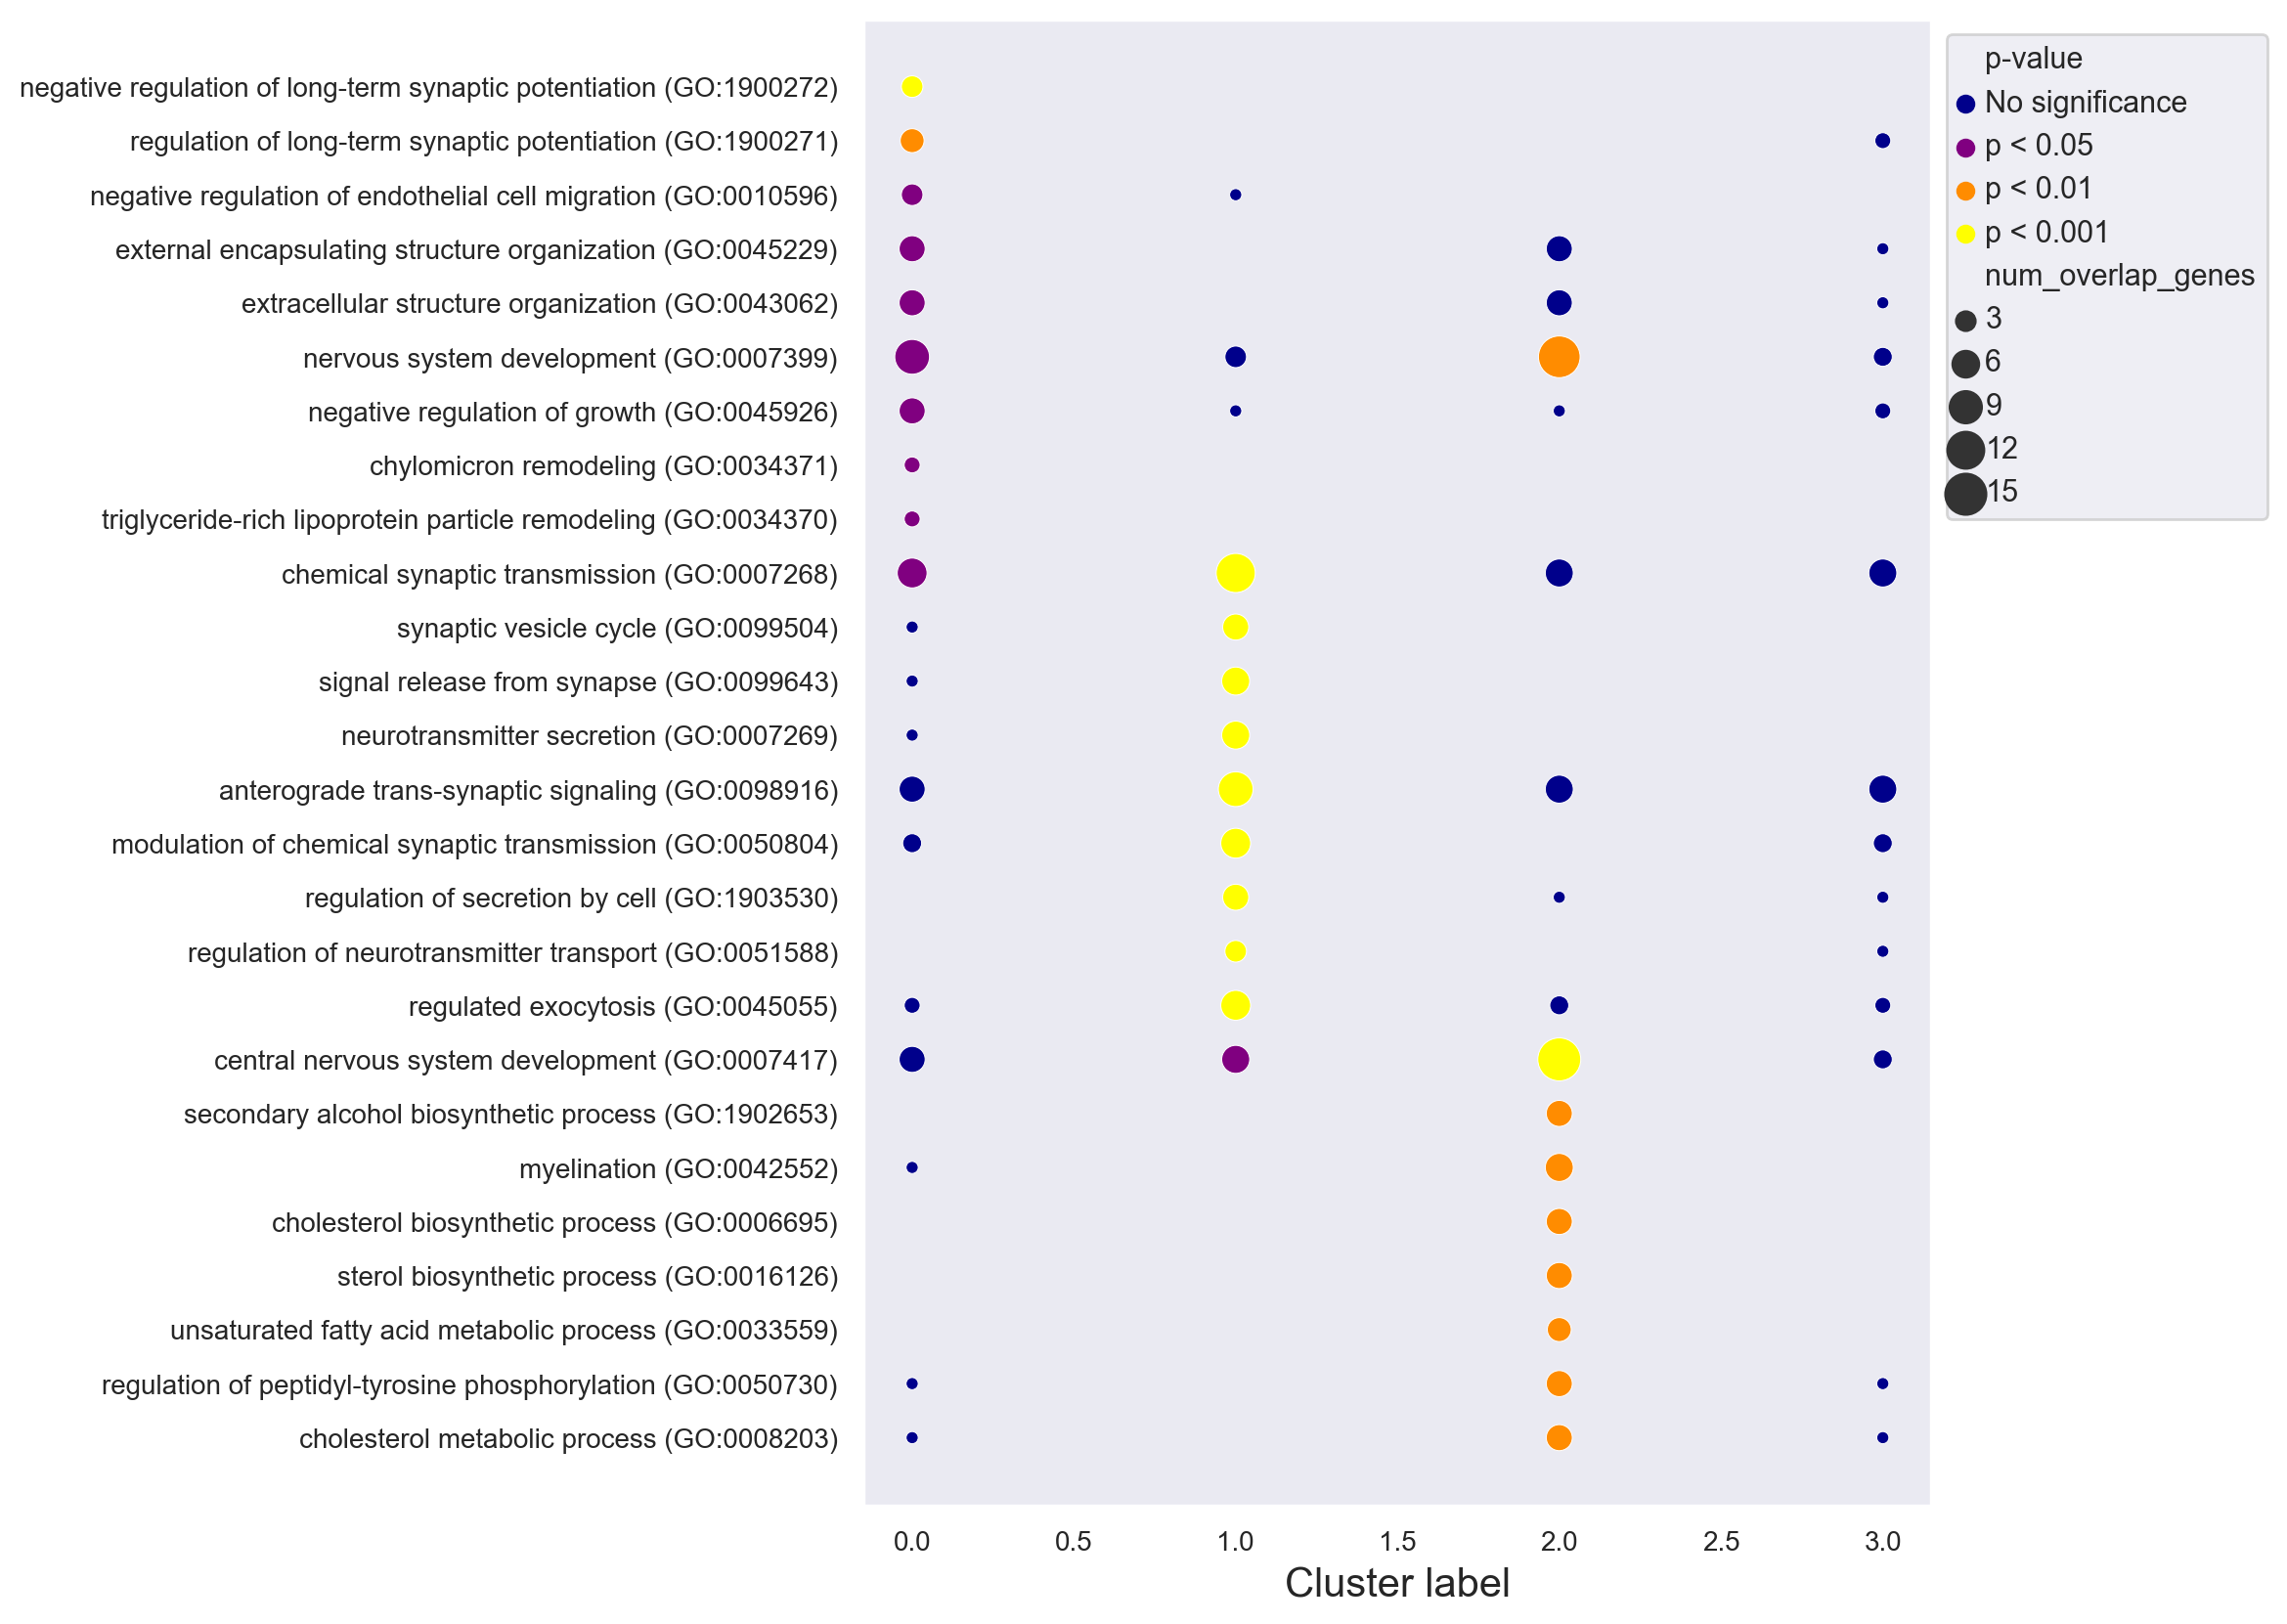

In [36]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [37]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [38]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Astrocyte 2 CL0000127                                  1  0.000015   
Vascular Lepotomeningeal Cell CL2000043                2  0.000251   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...     3  0.000499   
FGFR3+ PLCG1+ Layer 1-6 Astrocyte CL0000127            4  0.001233   
LAMP5+ BMP2+ Layer 1 GABAergic Neuron CL0000617        5  0.001716   

                                                       Z-score  \
Term                                                             
Astrocyte 2 CL0000127                               111.219512   
Vascular Lepotomeningeal Cell CL2000043             219.807229   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...  109.891566   
FGFR3+ PLCG1+ Layer 1-6 Astrocyte CL0000127          54.933735   
LAMP5+ BMP2+ Layer 1 GABAergic Neuron CL0000617      43.942169   

                                                    Combined score  \
Term                                                                 
Astrocyte 2 CL0000127                                  1236.236010   
Vascular Lepotomeningeal Cell CL2000043                1822.098319   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...      835.439755   
FGFR3+ PLCG1+ Layer 1-6 Astrocyte CL0000127             367.953919   
LAMP5+ BMP2+ Layer 1 GABAergic Neuron CL0000617         279.809643   

                                                        Overlapping genes  \
Term                                                                        
Astrocyte 2 CL0000127                               [SLC1A3, APOE, FGFR3]   
Vascular Lepotomeningeal Cell CL2000043                  [COL1A2, COL6A2]   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...       [COL1A2, COL6A2]   
FGFR3+ PLCG1+ Layer 1-6 Astrocyte CL0000127                [NDRG2, FGFR3]   
LAMP5+ BMP2+ Layer 1 GABAergic Neuron CL0000617            [RELN, CXCL14]   

                                                    Adjusted P-value  \
Term                                                                   
Astrocyte 2 CL0000127                                       0.000982   
Vascular Lepotomeningeal Cell CL2000043                     0.008287   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...          0.010984   
FGFR3+ PLCG1+ Layer 1-6 Astrocyte CL0000127                 0.016181   
LAMP5+ BMP2+ Layer 1 GABAergic Neuron CL0000617             0.016181   

                                                    Old p-value  \
Term                                                              
Astrocyte 2 CL0000127                                         0   
Vascular Lepotomeningeal Cell CL2000043                       0   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...            0   
FGFR3+ PLCG1+ Layer 1-6 Astrocyte CL0000127                   0   
LAMP5+ BMP2+ Layer 1 GABAergic Neuron CL0000617               0   

                                                    Old adjusted p-value  \
Term                                                                       
Astrocyte 2 CL0000127                                                  0   
Vascular Lepotomeningeal Cell CL2000043                                0   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...                     0   
FGFR3+ PLCG1+ Layer 1-6 Astrocyte CL0000127                            0   
LAMP5+ BMP2+ Layer 1 GABAergic Neuron CL0000617                        0   

                                                    num_overlap_genes  \
Term                                                                    
Astrocyte 2 CL0000127                                               3   
Vascular Lepotomeningeal Cell CL2000043                             2   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...                  2   
FGFR3+ PLCG1+ Layer 1-6 Astrocyte CL0000127                         2   
LAMP5+ BMP2+ Layer 1 GABAergic Neuron CL0000617                     2   

                                               

In [39]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

32

In [40]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

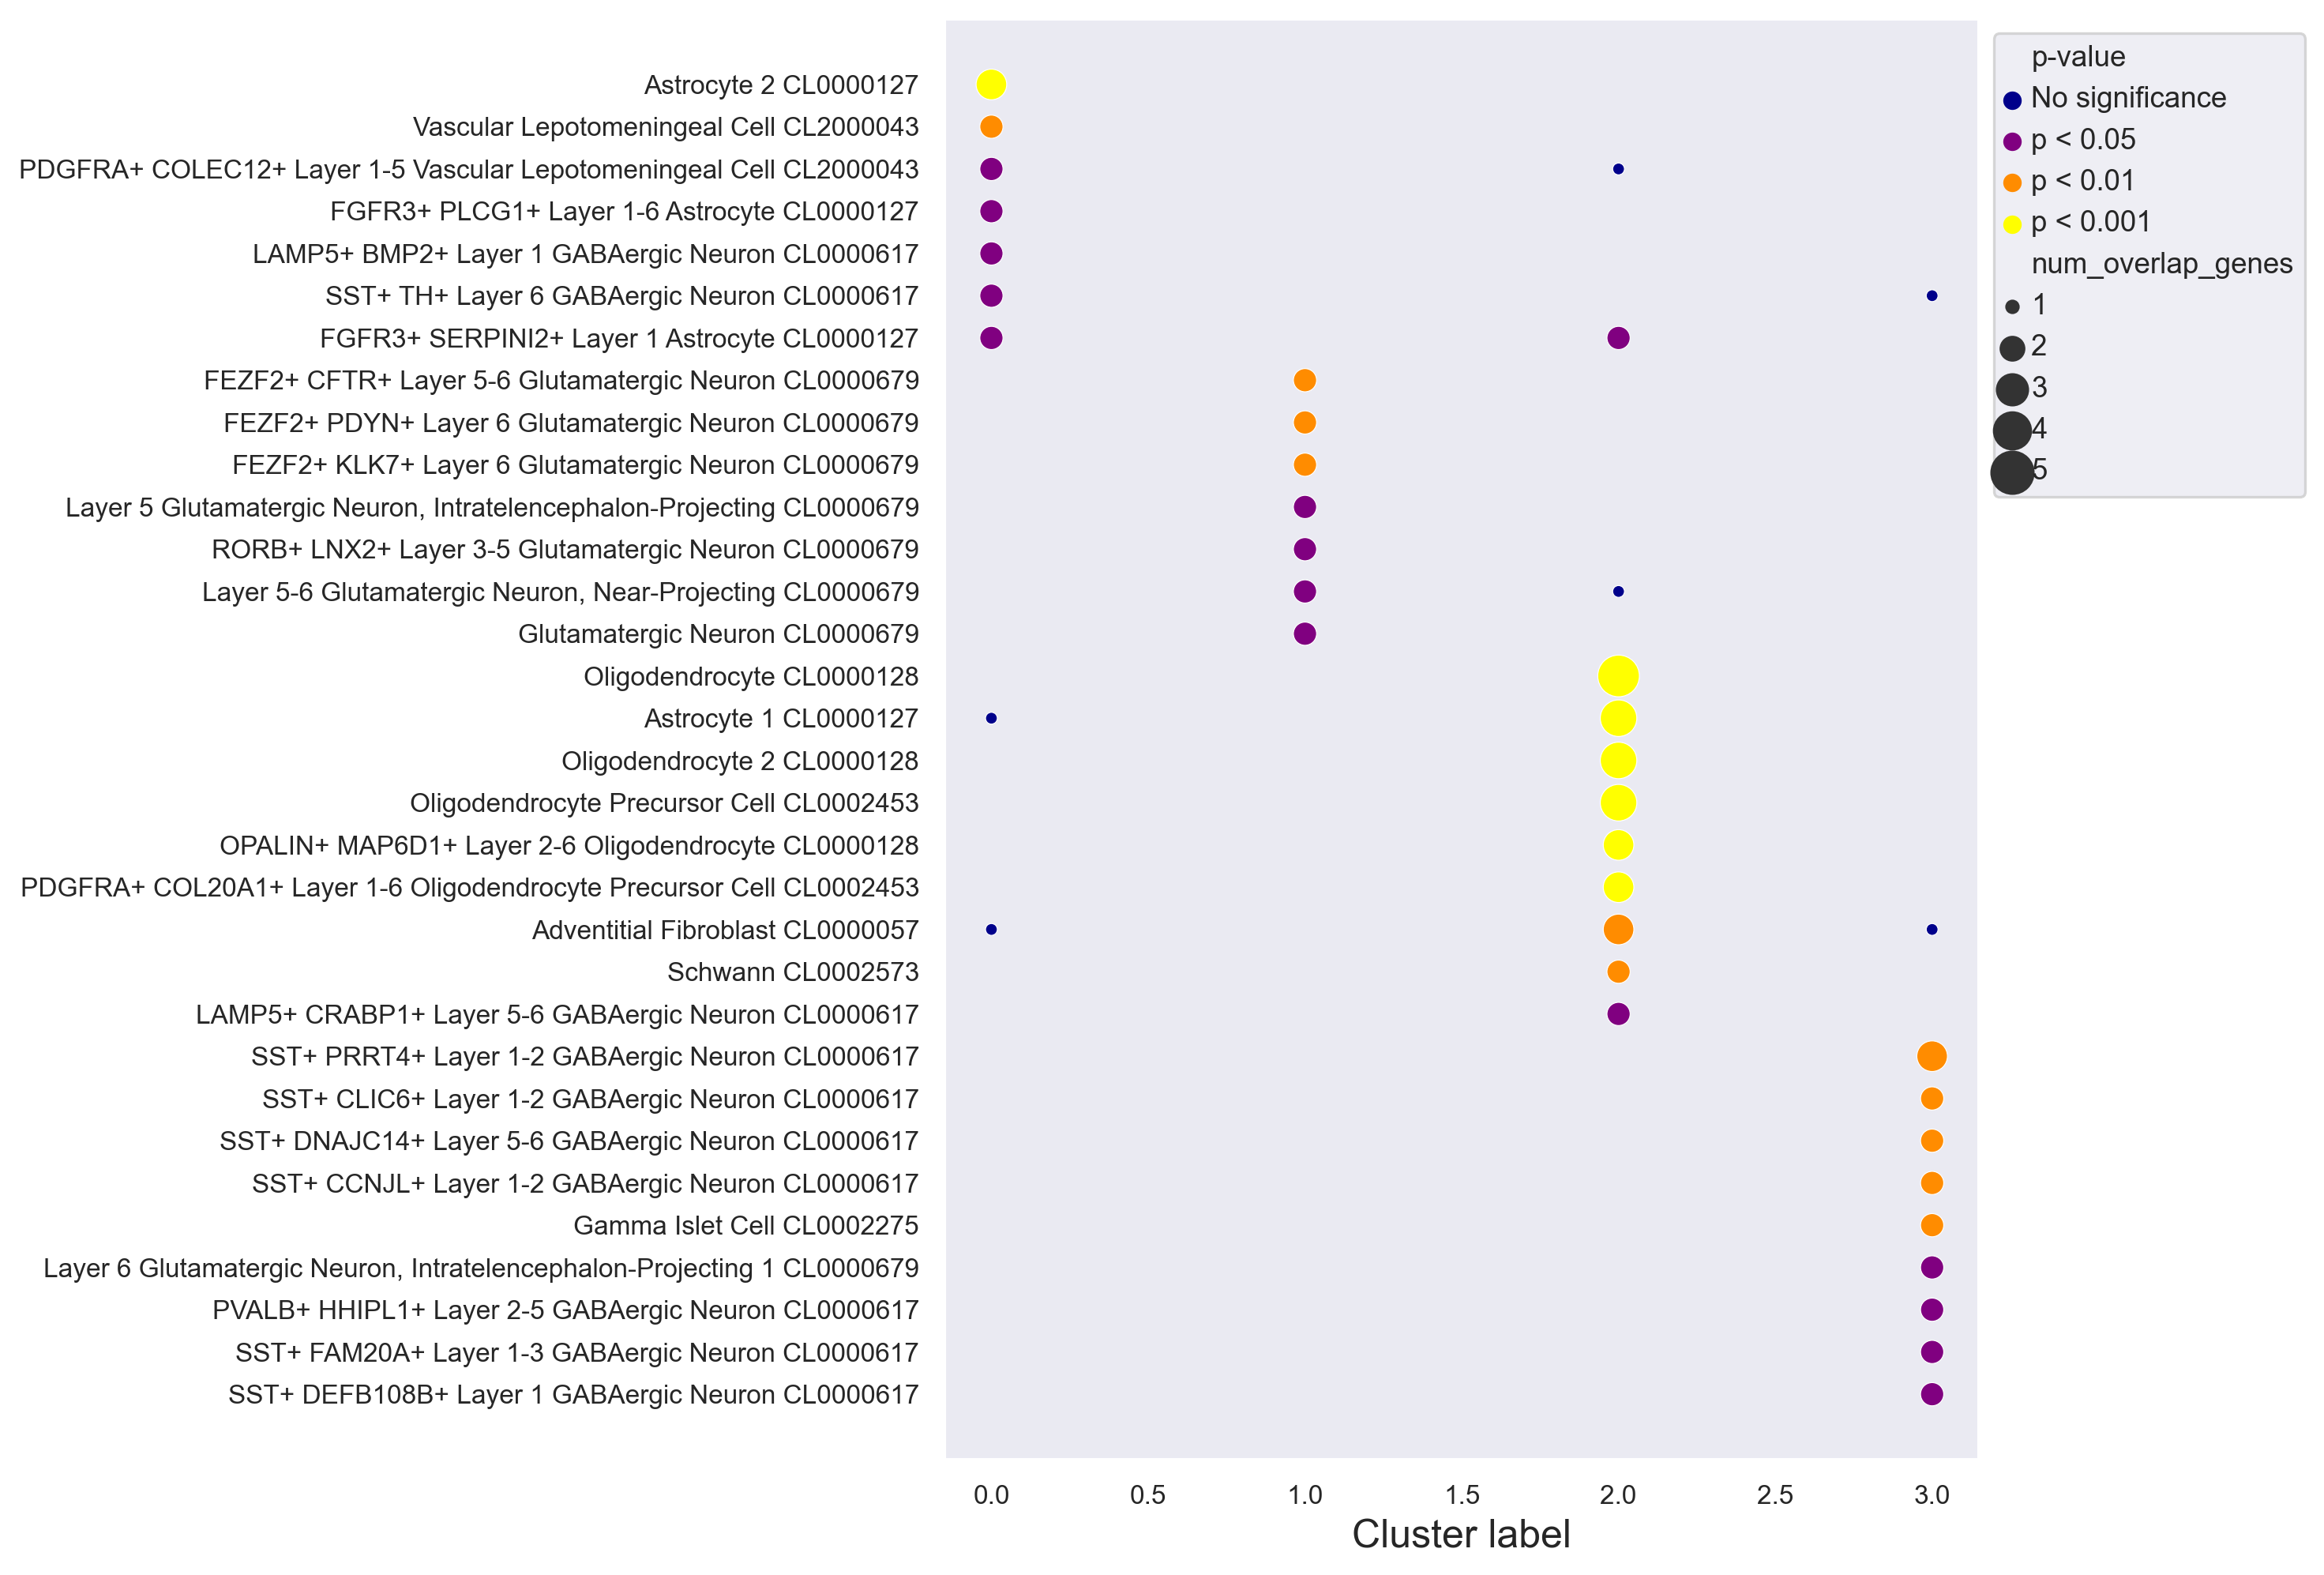

In [41]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [42]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [43]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
abnormal astrocyte physiology MP:0008916               1  0.000005   
abnormal Purkinje cell morphology MP:0000877           2  0.000157   
deafness MP:0001967                                    3  0.000393   
abnormal retinal inner nuclear layer morphology...     4  0.000435   
increased circulating phospholipid level MP:000...     5  0.000499   

                                                       Z-score  \
Term                                                             
abnormal astrocyte physiology MP:0008916             50.008230   
abnormal Purkinje cell morphology MP:0000877         11.117647   
deafness MP:0001967                                  13.201162   
abnormal retinal inner nuclear layer morphology...   12.822575   
increased circulating phospholipid level MP:000...  109.891566   

                                                    Combined score  \
Term                                                                 
abnormal astrocyte physiology MP:0008916                615.249165   
abnormal Purkinje cell morphology MP:0000877             97.374554   
deafness MP:0001967                                     103.519910   
abnormal retinal inner nuclear layer morphology...       99.253480   
increased circulating phospholipid level MP:000...      835.439755   

                                                                  Overlapping genes  \
Term                                                                                  
abnormal astrocyte physiology MP:0008916                [GRM3, APOE, HIVEP2, NDRG2]   
abnormal Purkinje cell morphology MP:0000877        [RELN, MAP2, SLC1A3, TPP1, VIM]   
deafness MP:0001967                                     [FBXO2, PMP22, APOE, FGFR3]   
abnormal retinal inner nuclear layer morphology...      [RELN, EPAS1, SLC1A3, APOE]   
increased circulating phospholipid level MP:000...                      [LPL, APOE]   

                                                    Adjusted P-value  \
Term                                                                   
abnormal astrocyte physiology MP:0008916                    0.004393   
abnormal Purkinje cell morphology MP:0000877                0.076042   
deafness MP:0001967                                         0.082721   
abnormal retinal inner nuclear layer morphology...          0.082721   
increased circulating phospholipid level MP:000...          0.082721   

                                                    Old p-value  \
Term                                                              
abnormal astrocyte physiology MP:0008916                      0   
abnormal Purkinje cell morphology MP:0000877                  0   
deafness MP:0001967                                           0   
abnormal retinal inner nuclear layer morphology...            0   
increased circulating phospholipid level MP:000...            0   

                                                    Old adjusted p-value  \
Term                                                                       
abnormal astrocyte physiology MP:0008916                               0   
abnormal Purkinje cell morphology MP:0000877                           0   
deafness MP:0001967                                                    0   
abnormal retinal inner nuclear layer morphology...                     0   
increased circulating phospholipid level MP:000...                     0   

                                                    num_overlap_genes  \
Term                                                                    
abnormal astrocyte physiology MP:0008916                            4   
abnormal Purkinje cell morphology MP:0000877                        5   
deafness MP:0001967                                                 4   
abnormal retinal inner nuclear layer morphology...                  4   
increased circulating phospholipid level MP:000... 

In [44]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

19

In [45]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

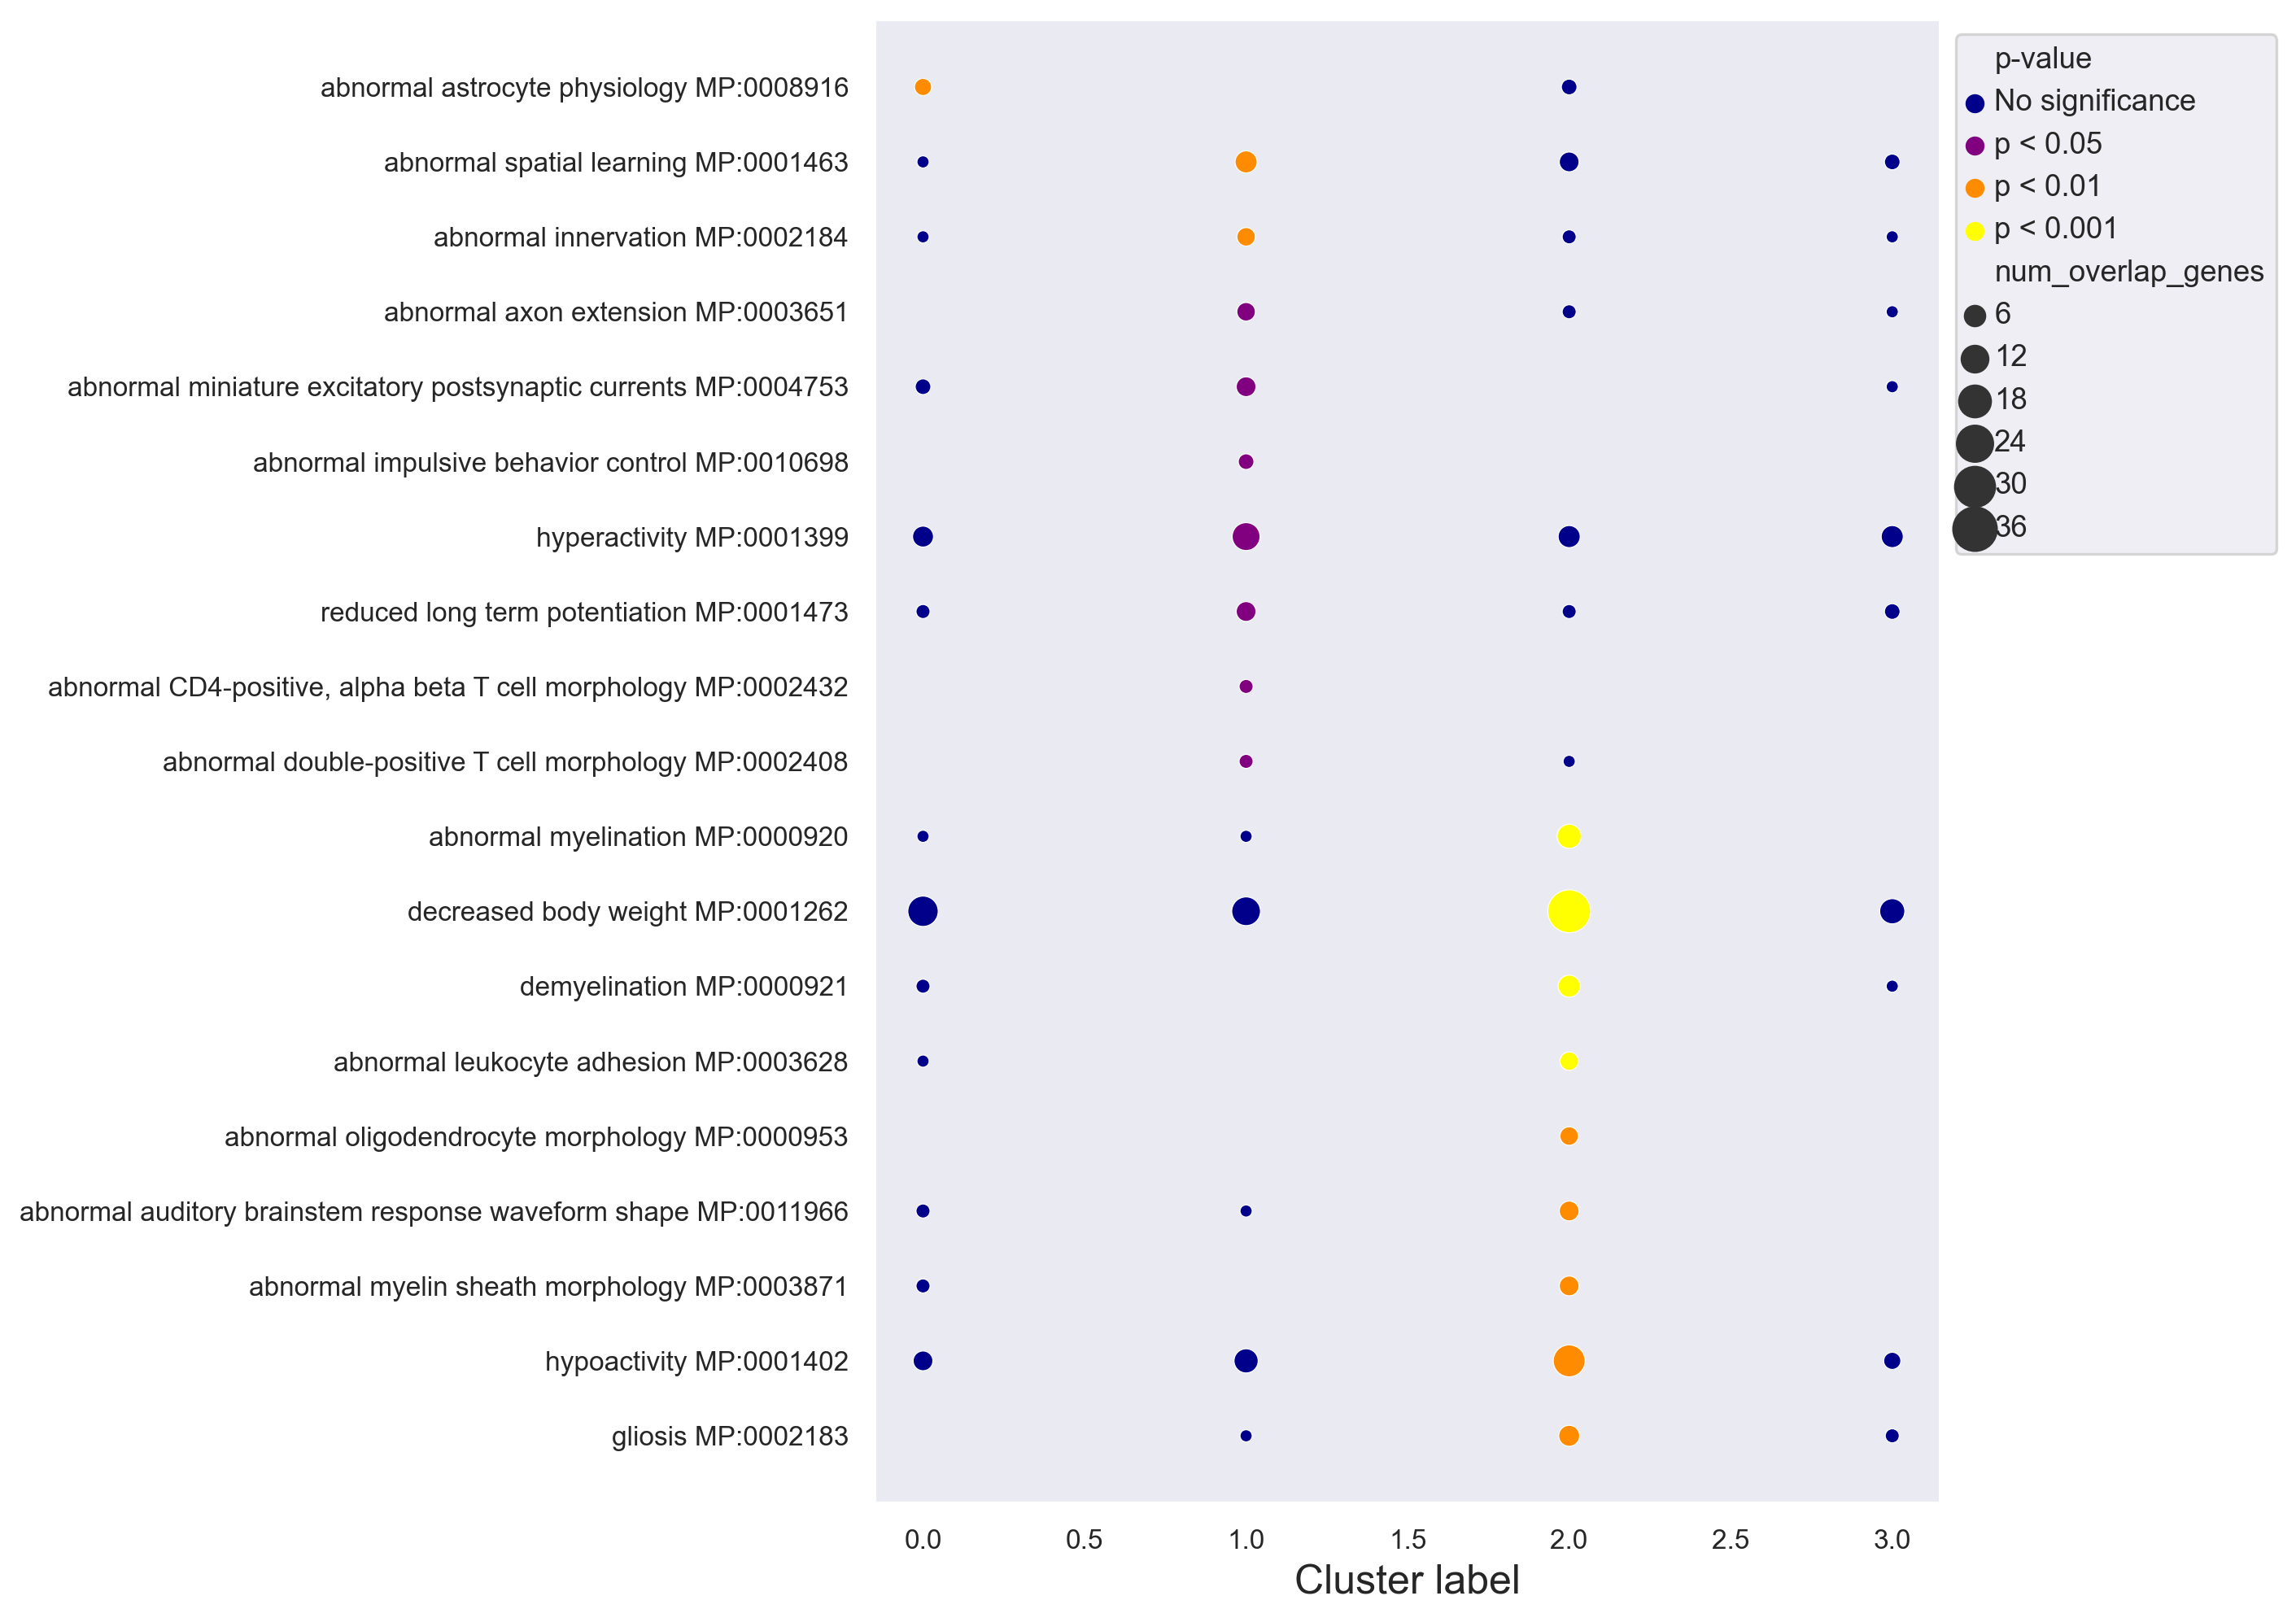

In [46]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [47]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [48]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Chylomicron Remodeling R-HSA-8963901                   1  0.000084   
Post-translational Protein Phosphorylation R-HS...     2  0.000171   
Regulation Of IGF Transport And Uptake By IGFBP...     3  0.000255   
Metallothioneins Bind Metals R-HSA-5661231             4  0.000499   
YAP1- And WWTR1 (TAZ)-stimulated Gene Expressio...     5  0.000827   

                                                       Z-score  \
Term                                                             
Chylomicron Remodeling R-HSA-8963901                       inf   
Post-translational Protein Phosphorylation R-HS...   10.902644   
Regulation Of IGF Transport And Uptake By IGFBP...    9.940789   
Metallothioneins Bind Metals R-HSA-5661231          109.891566   
YAP1- And WWTR1 (TAZ)-stimulated Gene Expressio...   73.253012   

                                                    Combined score  \
Term                                                                 
Chylomicron Remodeling R-HSA-8963901                           inf   
Post-translational Protein Phosphorylation R-HS...       94.569244   
Regulation Of IGF Transport And Uptake By IGFBP...       82.257572   
Metallothioneins Bind Metals R-HSA-5661231              835.439755   
YAP1- And WWTR1 (TAZ)-stimulated Gene Expressio...      519.920029   

                                                                      Overlapping genes  \
Term                                                                                      
Chylomicron Remodeling R-HSA-8963901                                        [LPL, APOE]   
Post-translational Protein Phosphorylation R-HS...  [IGFBP4, SCG3, APOE, MFGE8, CHRDL1]   
Regulation Of IGF Transport And Uptake By IGFBP...  [IGFBP4, SCG3, APOE, MFGE8, CHRDL1]   
Metallothioneins Bind Metals R-HSA-5661231                                 [MT1M, MT1E]   
YAP1- And WWTR1 (TAZ)-stimulated Gene Expressio...                        [CCN2, HIPK1]   

                                                    Adjusted P-value  \
Term                                                                   
Chylomicron Remodeling R-HSA-8963901                        0.032592   
Post-translational Protein Phosphorylation R-HS...          0.032878   
Regulation Of IGF Transport And Uptake By IGFBP...          0.032878   
Metallothioneins Bind Metals R-HSA-5661231                  0.048303   
YAP1- And WWTR1 (TAZ)-stimulated Gene Expressio...          0.064017   

                                                    Old p-value  \
Term                                                              
Chylomicron Remodeling R-HSA-8963901                          0   
Post-translational Protein Phosphorylation R-HS...            0   
Regulation Of IGF Transport And Uptake By IGFBP...            0   
Metallothioneins Bind Metals R-HSA-5661231                    0   
YAP1- And WWTR1 (TAZ)-stimulated Gene Expressio...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Chylomicron Remodeling R-HSA-8963901                                   0   
Post-translational Protein Phosphorylation R-HS...                     0   
Regulation Of IGF Transport And Uptake By IGFBP...                     0   
Metallothioneins Bind Metals R-HSA-5661231                             0   
YAP1- And WWTR1 (TAZ)-stimulated Gene Expressio...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Chylomicron Remodeling R-HSA-8963901                                2   
Post-translational Protein Phosphorylation R-HS...                  5   
Regulation Of IGF Transport And Uptake By IGFBP...                  5   
Metallothioneins Bind Metals R-HSA-5661231                          2   
YAP1- And WWTR1 (TAZ)-s

In [49]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

15

In [50]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

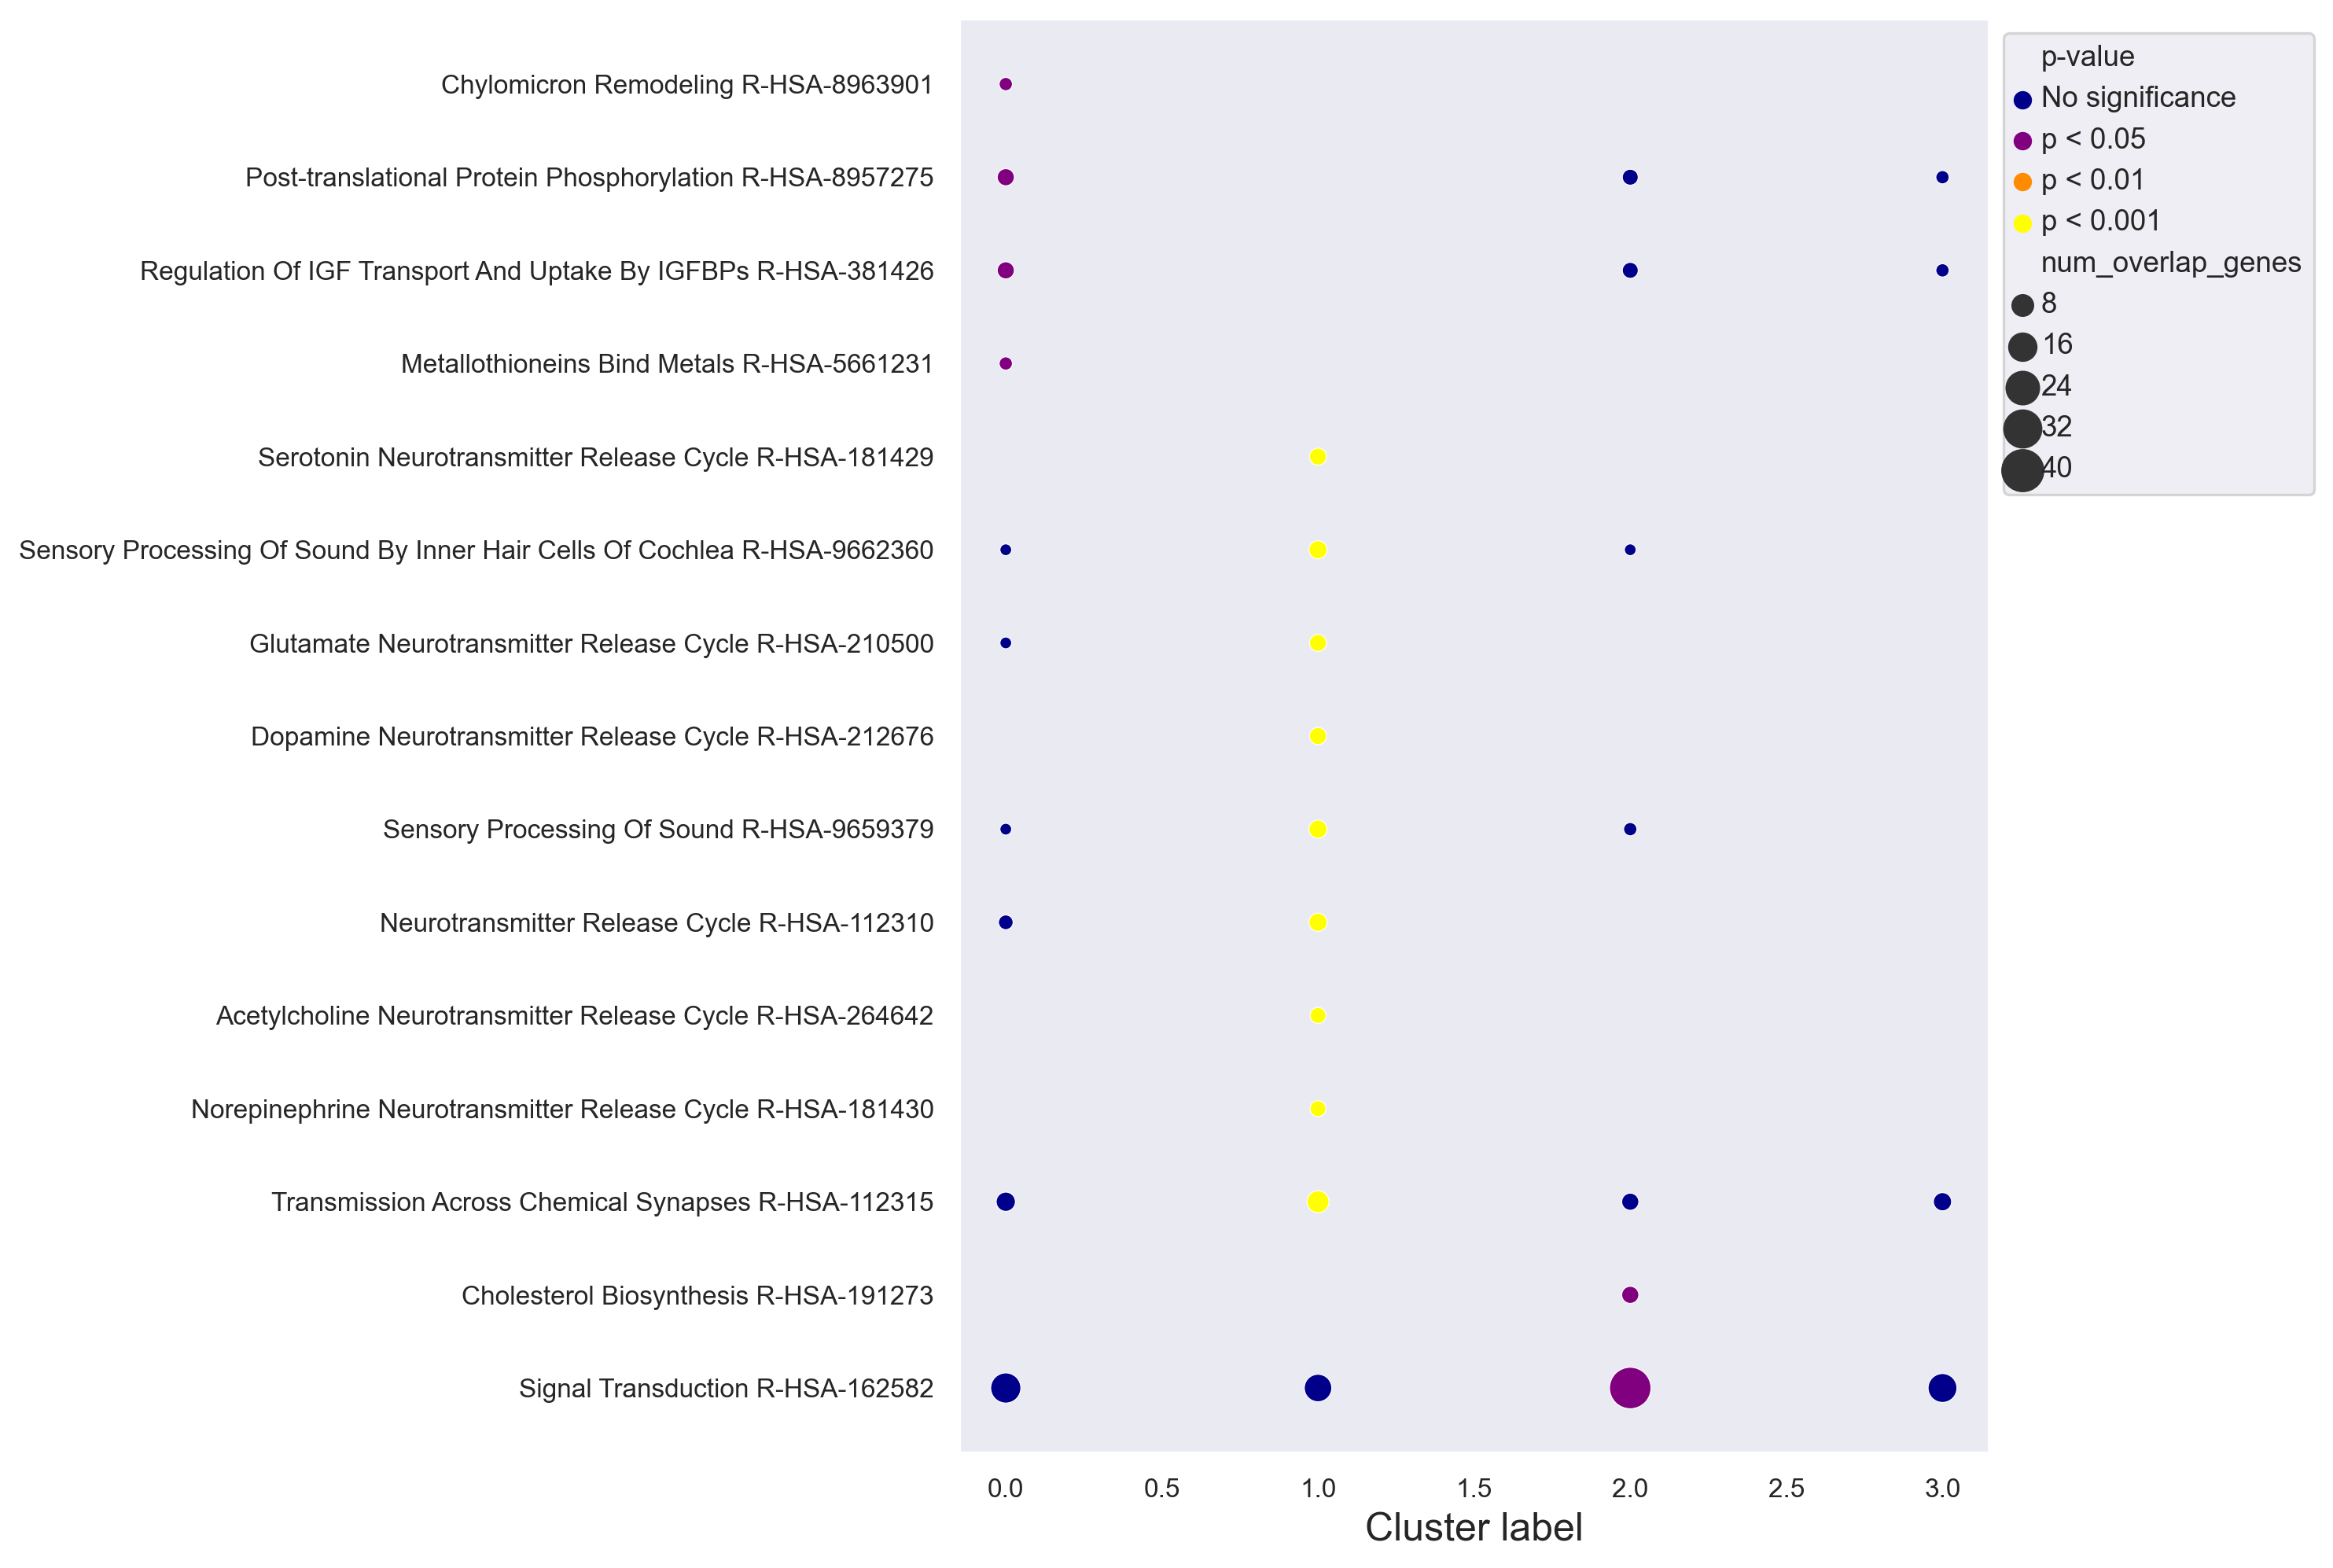

In [51]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [52]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [53]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                 
Protein digestion and absorption            1  0.000117  18.722222   
Glutamatergic synapse                       2  0.001095   7.064844   
Neuroactive ligand-receptor interaction     3  0.001346   6.725446   
Nicotine addiction                          4  0.001693  14.475080   
Mineral absorption                          5  0.002333  12.800657   

                                         Combined score  \
Term                                                      
Protein digestion and absorption             169.508591   
Glutamatergic synapse                         48.163467   
Neuroactive ligand-receptor interaction       44.459958   
Nicotine addiction                            92.367800   
Mineral absorption                            77.581939   

                                                                Overlapping genes  \
Term                                                                                
Protein digestion and absorption                    [COL1A2, ELN, COL6A2, ATP1B2]   
Glutamatergic synapse                         [GRM3, GRIN3A, SLC1A3, GRIK1, GLUL]   
Neuroactive ligand-receptor interaction  [GRM3, ADCYAP1R1, GRIN3A, GRIK1, GABRG1]   
Nicotine addiction                                      [GRIN3A, SLC32A1, GABRG1]   
Mineral absorption                                           [MT1M, ATP1B2, MT1E]   

                                         Adjusted P-value  Old p-value  \
Term                                                                     
Protein digestion and absorption                 0.012629            0   
Glutamatergic synapse                            0.045715            0   
Neuroactive ligand-receptor interaction          0.045715            0   
Nicotine addiction                               0.045715            0   
Mineral absorption                               0.050384            0   

                                         Old adjusted p-value  \
Term                                                            
Protein digestion and absorption                            0   
Glutamatergic synapse                                       0   
Neuroactive ligand-receptor interaction                     0   
Nicotine addiction                                          0   
Mineral absorption                                          0   

                                         num_overlap_genes  neg_log10(p_adj)  \
Term                                                                           
Protein digestion and absorption                         4          1.898623   
Glutamatergic synapse                                    5          1.339939   
Neuroactive ligand-receptor interaction                  5          1.339939   
Nicotine addiction                                       3          1.339939   
Mineral absorption                                       3          1.297709   

                                         cluster_label  
Term                                                    
Protein digestion and absorption                     0  
Glutamatergic synapse                                0  
Neuroactive ligand-receptor interaction              0  
Nicotine addiction                                   0  
Mineral absorption                                   0

In [54]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

12

In [55]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

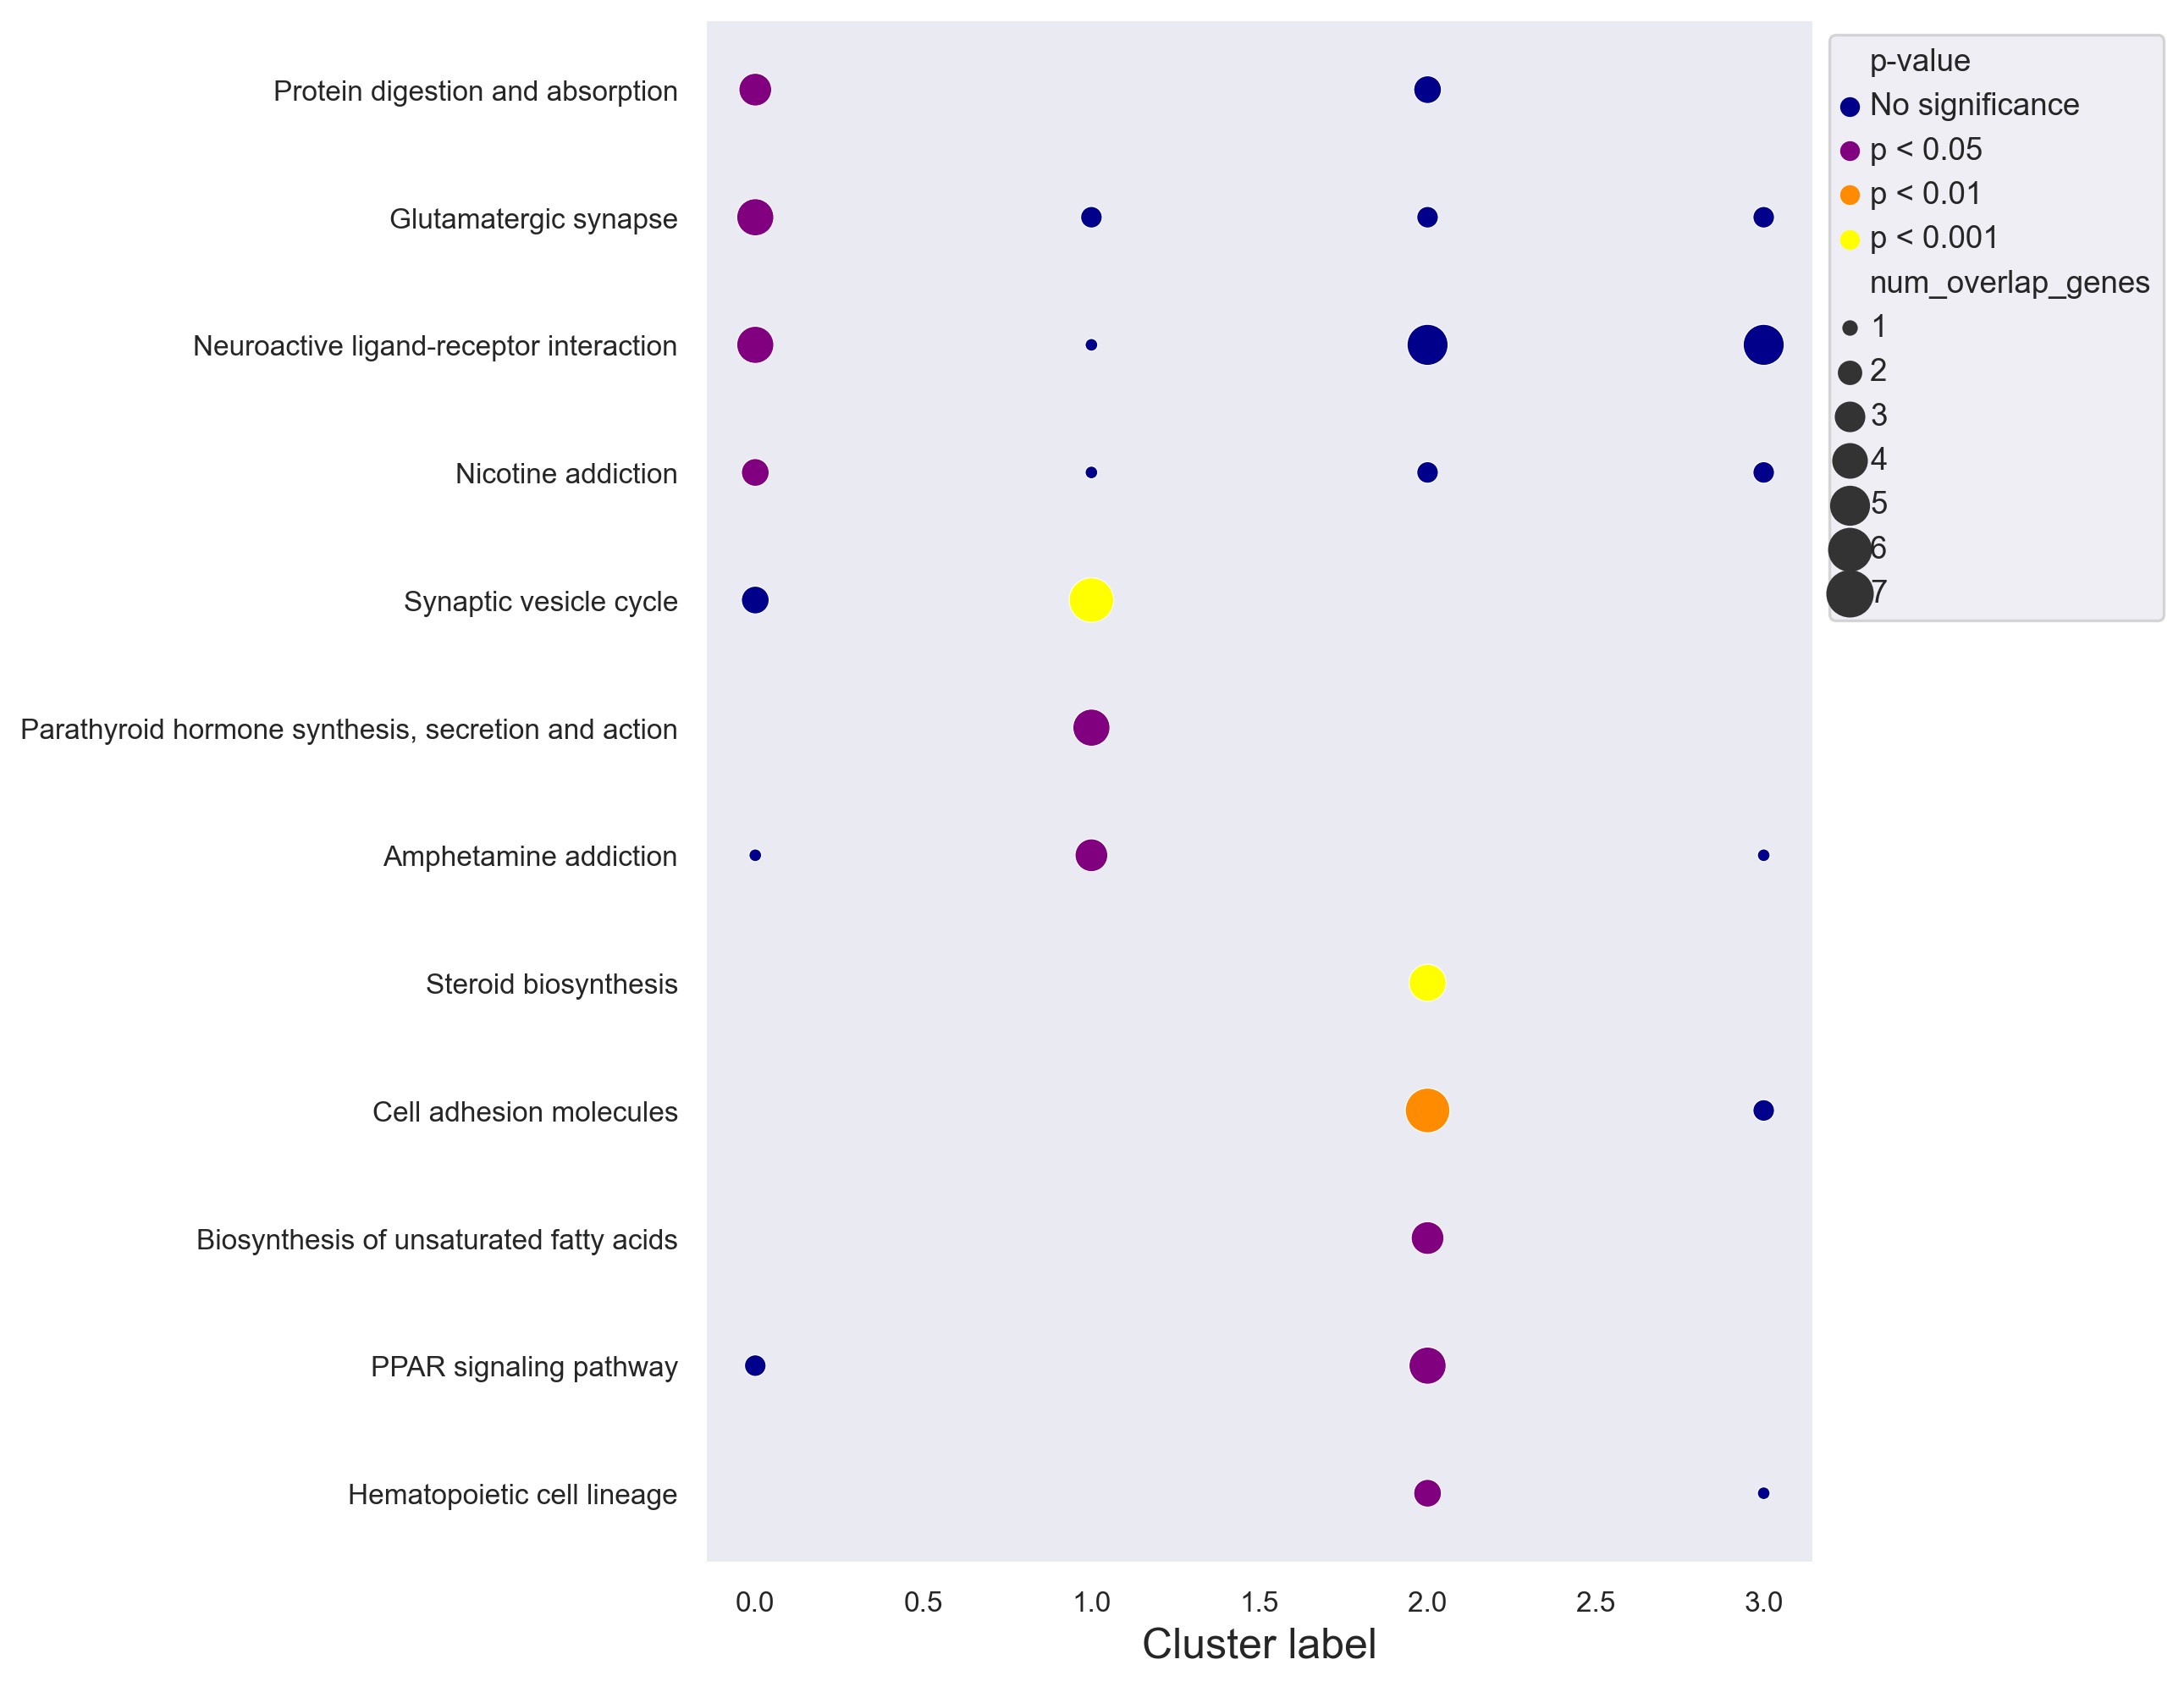

In [56]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))